In [3]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [4]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [68]:
from patchseq_utils import plotting as plot, analysis as utils
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')
pd.options.display.max_columns=300
pd.options.display.max_rows=300

In [6]:
from neuron_morphology.swc_io import morphology_from_swc
from patchseq_utils.lims import get_swc_path

In [10]:
mouse_df = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
human_l12 = human_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2') & (df['normalized_layer_depth'] < 0.2))]
mouse_l12 = mouse_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2/3') & (df['normalized_layer_depth'] < 0.2))]
combined_l12 = pd.concat([human_l12, mouse_l12], 
                           sort=False).dropna(subset=['homology_type']).copy()

In [35]:
from collections import defaultdict


from neuron_morphology.constants import (
    SOMA, AXON, APICAL_DENDRITE, BASAL_DENDRITE)

def visit(morphology, node, index, step, dist, dendro):
    if node['type'] == SOMA:
        return index, dist
    compartment = morphology.get_compartment_for_node(node)
    dist += morphology.get_compartment_length(compartment)
            
    if dist >= index*step:
        # area = np.pi*(node['radius']**2)
        dendro[index].append(node['radius'])
        index += 1
    return index, dist

def calculate_cross_section_profile(morphology, root=None, index=0, step=5, dist=0, dendro=None, node_types=None):
    if index==2:
        return dendro
    if node_types is None:
        node_types = [SOMA, AXON, APICAL_DENDRITE, BASAL_DENDRITE]
    if root is None:
        root = morphology.get_root()
    if dendro is None:
        dendro = defaultdict(list)
    
    index, dist = visit(morphology, root, index, step, dist, dendro)
    
    while len(morphology.get_children(root)) > 0:
        children = morphology.get_children(root)
        # the next node is a continuation from this node 
        if len(children) == 1:
            root = children[0]
            index, dist = visit(morphology, root, index, step, dist, dendro)
        else:
            # we reached a bifurcation point
            for child in children:
                if child['type'] in node_types:
                    dendro = calculate_cross_section_profile(morphology, child, index, step, dist, dendro, node_types)
            break
            
    return dendro

In [15]:
def get_profiles(cells):
    profiles = {}
    for cell in cells:
        path = get_swc_path(cell)
        morphology = morphology_from_swc(path)
        dend = calculate_cross_section_profile(morphology, node_types=[BASAL_DENDRITE])
        profiles[cell] = list(map(np.sum, dend.values()))
    return profiles

In [16]:
human_profiles = get_profiles(human_l12.query('has_morph').index)

mouse_profiles = get_profiles(mouse_l12.query('has_morph').index)

In [17]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [49]:
def get_volume(profiles, step=5):
    return step*np.sum(profiles)

def get_peak(profiles, step=5, start=10):
    i = start//step
    if len(profiles) <= i:
        return 0
    else:
        return np.max(profiles[i:])
    

In [50]:
data = pd.Series(mouse_profiles)
mouse_l12 = mouse_l12.assign(dendrite_volume=data.map(get_volume), dendrite_cross_section_peak=data.map(get_peak))
data = pd.Series(human_profiles)
human_l12 = human_l12.assign(dendrite_volume=data.map(get_volume), dendrite_cross_section_peak=data.map(get_peak))
combined = pd.concat([mouse_l12, human_l12], sort=False)

In [32]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

In [42]:
get_peak(data.iloc[0])

3.201618750262668

In [48]:
utils.subgroup_comparisons(combined,['dendrite_cross_section_peak'],  'homology_type', 'species')

,sig_groups,PAX6,MC4R,LAMP5,L1 VIP
feature,,,,,
dendrite_cross_section_peak,,0.6,0.102456,0.818432,0.460606


In [77]:
human_l12.head()

,exp_component_name,old_layer,batch,cell_name,spec_id.1,donor,collaborator,gender,collection,medical_conditions,postPatch,postPatch_classification,filldate,rigOperator,rigNumber,cell_depth,sliceHealth,patchseq_roi,roi,Class,injection_roi,injection_method,injection_materials,propagation_type,Total_time,Ephys_time,Retraction_time,endPipetteR,rna_amplification_pass_fail,go_no_go_63x,image_series_63x_qc,cell_specimen_project,percent_reads_aligned_total,percent_reads_aligned_to_exons,genes,patch_date,exclude,fpkm_dir,MALAT1_cpm,Depth_from_Pia_microns,total_cortical_depth,L23_cell_depth,L23_total_thickness,virus,recon_cell_overall_state,recon_layer_type,cluster,score,n_marker,res_index,h_score,res_index_pctile,topLeafValue,last_map,last_res,last_score,code_version,ref_version,mapping_version,sample_id,cell_reporter,marker_genes,topLeaf,quality_score,marker_sum_norm,Norm_Marker_Sum.0.4,contaminationType,contam_sum,seurat_cluster,seurat_prediction_score,broad_class,subclass,Tree_first_cl,Tree_second_cl,Tree_third_cl,Tree_first_bt,Tree_second_bt,Tree_third_bt,Tree_first_KL,Tree_second_KL,Tree_third_KL,Tree_first_cor,Tree_second_cor,Tree_third_cor,Tree_call,Old_call,name,created_at,normalized_depth_lims,soma_depth_um,structure,hemisphere,donor_name,dendrite_type,img_status,layer_lims,project_code,err_id,nwb_path,nwb_type,reconstruction_tag,swc_path,species,t-type,slice,has_morph,ephys_format,target_layer,has_ephys,tx_qc,homology_type,core_l1_type,l1_type,blowout_mv_qc,electrode_0_pa_qc,recording_date_qc,seal_gohm_qc,input_resistance_mohm_qc,initial_access_resistance_mohm_qc,input_access_resistance_ratio_qc,fail_tags_qc,failed_blowout,failed_electrode_0,failed_seal,failed_input_access_resistance,failed_qc,failed_fx_long_squares,failed_fx_short_squares,failed_fx_ramps,failed_fx_chirps,failed_fx_sweep_features,upstroke_downstroke_ratio_ramp,threshold_v_ramp,width_ramp,upstroke_ramp,downstroke_ramp,width_suprathresh_ramp,trough_v_ramp,threshold_i_ramp,postap_slope_ramp,fast_trough_deltav_ramp,peak_deltav_ramp,peak_ratio_chirp,peak_freq_chirp,3db_freq_chirp,peak_impedance_chirp,low_freq_impedance_chirp,sync_freq_chirp,phase_peak_chirp,phase_low_chirp,total_inductive_phase_chirp,sag,sag_area,sag_tau,v_baseline,rheobase_i,fi_fit_slope,vm_for_sag,input_resistance,input_resistance_ss,tau,latency_rheo,avg_rate_rheo,mean_isi_rheo,upstroke_downstroke_ratio_rheo,threshold_v_rheo,peak_v_rheo,width_rheo,upstroke_rheo,downstroke_rheo,width_suprathresh_rheo,trough_v_rheo,fast_trough_v_rheo,postap_slope_rheo,fast_trough_v_last_rheo,adp_v_last_rheo,adapt_hero,avg_rate_hero,latency_hero,mean_isi_hero,median_isi_hero,isi_cv_hero,ir_late_hero,upstroke_downstroke_ratio_hero,threshold_v_hero,peak_v_hero,width_hero,upstroke_hero,downstroke_hero,width_suprathresh_hero,trough_v_hero,fast_trough_v_hero,postap_slope_hero,ahp_delay_ratio_hero,sag_depol,sag_area_depol,sag_tau_depol,adapt_mean,isi_cv_mean,ir_late_mean,avg_rate_max,isi_adapt_ratio,width_adapt_ratio,upstroke_adapt_ratio,downstroke_adapt_ratio,threshold_v_adapt_ratio,peak_v_adapt_ratio,ahp_delay_ratio_5spike,trough_slowdeltav_rheo,trough_slowdeltav_hero,fast_trough_deltav_rheo,fast_trough_deltav_hero,peak_deltav_rheo,peak_deltav_hero,first_isi_inv_rheo,first_isi_inv_hero,upstroke_downstroke_ratio_short_square,threshold_v_short_square,width_short_square,upstroke_short_square,downstroke_short_square,width_suprathresh_short_square,peak_deltav_short_square,image_series_id,errors,layer_depth,layer_thickness,normalized_layer_depth,normalized_depth,absolute_depth,cortex_thickness,wm_distance,layer,axon_bias_x,axon_bias_y,axon_depth_pc_0,axon_depth_pc_1,axon_depth_pc_2,axon_depth_pc_3,axon_depth_pc_4,axon_emd_with_basal_dendrite,axon_exit_distance,axon_exit_theta,axon_extent_x,axon_extent_y,axon_frac_above_basal_dendrite,axon_frac_below_basal_dendrite,axon_frac_intersect_basal_dendrite,axon_max_branch_order,axon_max_euclidean_distance,axon_max_path_distance,axon_mean_contraction,axon_num_branches,axon_soma_perce

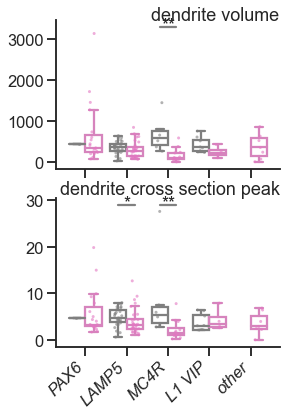

In [51]:
features = ['dendrite_volume', 'dendrite_cross_section_peak']
# utils.plot_boxplot_multiple(data=human_l12, x='homology_type', features=features, palette=palette_subclass)
labels = feature_name
utils.plot_boxplot_multiple(data=combined, 
                            x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=True,
               palette=species_palette, figsize=(4,6))

In [59]:
def plot_profiles(profiles, color=species_palette['human'], step=5):
    for profile in profiles:
        plt.plot(step*np.arange(len(profile)), profile, color=color, alpha=0.5)
    mean = pd.DataFrame(profiles).fillna(0).mean(axis=0)
    plt.plot(step*np.arange(len(mean)), mean, 'k')
    plt.ylim(0, 15)
    plt.xlim(0, 300)
    plt.xlabel('dist from soma (µm)')
    plt.ylabel('cross-sectional area ($µm^2$)')
    plt.show()

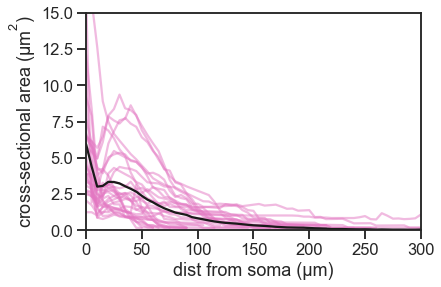

In [60]:
plot_profiles([human_profiles[x] for x in human_l12.query("homology_type=='LAMP5'").index if x in human_profiles])

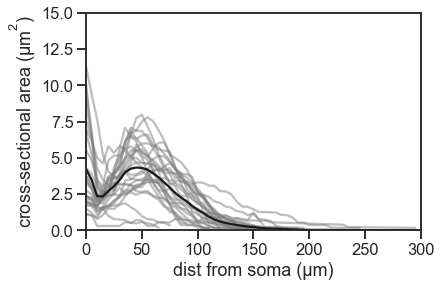

In [61]:
plot_profiles([mouse_profiles[x] for x in mouse_l12.query("homology_type=='LAMP5'").index if x in mouse_profiles], color=species_palette['mouse'])

In [63]:
import patchseq_utils.plot.morphology as pm

In [85]:
human = get_shiny('human')

human_l12 = human_l12.join(human['reconstruction_type'])

In [99]:
cells = human_l12.query("homology_type=='LAMP5' & dendrite_cross_section_peak>7.5")
cells.loc[:,['collaborator','cell_name','reconstruction_type', 'axon_bias_x', 'layer', 't-type', 'structure']]
# for x in cells.swc_path:
#     print(x)

,collaborator,cell_name,reconstruction_type,axon_bias_x,layer,t-type,structure
spec_id,,,,,,,
756894558,Gabor,H18.28.025.11.07.02,100x,16.708815,1,LAMP5 NMBR,SOG
853712464,Gabor,H19.28.009.11.05.02,63x,91.742108,1,LAMP5 NMBR,IOG
1038295890,Gabor,H20.28.022.11.05.02,63x,42.092315,1,LAMP5 LCP2,FroL
1031689414,Gabor,H20.28.011.11.05.05,63x,96.099062,1,LAMP5 LCP2,FroL


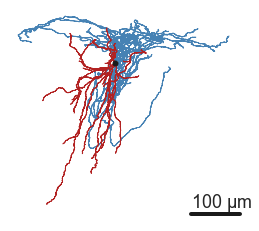

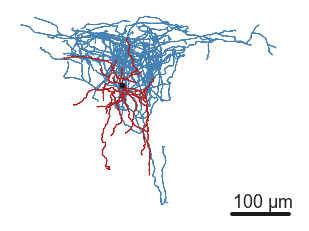

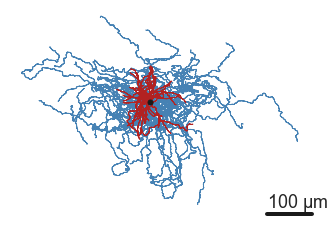

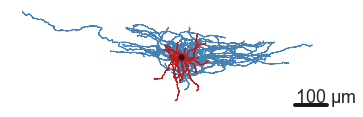

In [66]:
# top two cells are uncannily similar!!
for cell in cells.index:
    pm.plot_cell_lims(cell, rotate=180)

In [ ]:
#plot dendrogram?